# TODO: 
1. import of hnx in first cell.

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from hnx.core.hypergraph import Hypergraph
from hnx.linalg.linalg import compute_multiorder_laplacian, laplacian_matrices_all_orders
from hnx.dynamics.synch import higher_order_MSF

from scipy.linalg import eigh

np.random.seed(123)

In [3]:
# definition of the higher-order network
edge_list = [[0,7],[1,2],[1,7],[2,7],[3,7],[4,7],[5,7],[6,7],[1,2,7],[4,5,6],[4,5,7],[4,6,7],[5,6,7],[4,5,6,7]]
hypergraph = Hypergraph(edge_list)

N = hypergraph.num_nodes()

# definition of the coupling coefficients, i.e., the strength of each order of interaction 
sigmas = [1,1,1]

## Analysis of the multiorder Laplacian matrix
Here we show how to analyze the multiorder Laplacian matrix defined for synchronization in higher-order networks.

Source: 

Lucas M., Cencetti G., Battiston F., _Multiorder Laplacian for synchronization in higher-order networks_, Physical Review Research *2*, 033410 (2020)


In [4]:
# We can compute the Laplacian matrix for the different orders of interaction with
laplacians = laplacian_matrices_all_orders(hypergraph)

# for instance, the Laplacian matrix of order 2, i.e., the Laplacian matrix for three-body interactions, is given by
print(laplacians[2].todense())


[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2. -1.  0.  0.  0.  0. -1.]
 [ 0. -1.  2.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6. -2. -2. -2.]
 [ 0.  0.  0.  0. -2.  6. -2. -2.]
 [ 0.  0.  0.  0. -2. -2.  6. -2.]
 [ 0. -1. -1.  0. -2. -2. -2.  8.]]


In [5]:
# We can compute the multiorder Laplacian with
multiorder_laplacian = compute_multiorder_laplacian(hypergraph,sigmas)

print(multiorder_laplacian.toarray().round(3))

[[ 0.5    0.     0.     0.     0.     0.     0.    -0.5  ]
 [ 0.     2.067 -1.033  0.     0.     0.     0.    -1.033]
 [ 0.    -1.033  2.067  0.     0.     0.     0.    -1.033]
 [ 0.     0.     0.     0.5    0.     0.     0.    -0.5  ]
 [ 0.     0.     0.     0.     9.7   -3.067 -3.067 -3.567]
 [ 0.     0.     0.     0.    -3.067  9.7   -3.067 -3.567]
 [ 0.     0.     0.     0.    -3.067 -3.067  9.7   -3.567]
 [-0.5   -1.033 -1.033 -0.5   -3.567 -3.567 -3.567 13.767]]


In [6]:
# The stability of a system of Kuramoto oscillators depends on the spectrum of the multiorder Laplacian
spectrum = eigh(multiorder_laplacian.toarray(), eigvals_only=True)

print(spectrum)

[1.36175793e-16 5.00000000e-01 6.05839850e-01 1.44725527e+00
 3.10000000e+00 1.27666667e+01 1.27666667e+01 1.68135715e+01]


## Master Stability Function
Here we show how to evaluate the Master Stability Function for synchronization in higher-order networks.

Source: 

Gambuzza L.V., Di Patti F., Gallo L., Lepri S., Romance M., Criado R., Frasca M., Latora V., Boccaletti S., _Stability of synchronization in simplicial complexes_, Nature Communications *12*(1), 1-13 (2021)


We want to study the synchronization of a system of coupled dynamical systems in presence of with higher-order interactions. We assume the dynamics of the system to be governed by the equation:

${\dot{{\bf{x}}}}_{i}=	 \, {\bf{f}}({{\bf{x}}}_{i})+{\sigma }_{1}\mathop{\sum }\limits_{{j}_{1}=1}^{N}{a}_{i{j}_{1}}^{(1)}{{\bf{g}}}^{(1)}({{\bf{x}}}_{i},{{\bf{x}}}_{{j}_{1}}) \, 	+{\sigma }_{2}\mathop{\sum }\limits_{{j}_{1}=1}^{N}\mathop{\sum }\limits_{{j}_{2}=1}^{N}{a}_{i{j}_{1}{j}_{2}}^{(2)}{{\bf{g}}}^{(2)}({{\bf{x}}}_{i},{{\bf{x}}}_{{j}_{1}},{{\bf{x}}}_{{j}_{2}})+\ldots \, 	+{\sigma }_{D}\mathop{\sum }\limits_{{j}_{1}=1}^{N}...\mathop{\sum }\limits_{{j}_{D}=1}^{N}{a}_{i{j}_{1}....{j}_{D}}^{(D)}{{\bf{g}}}^{(D)}({{\bf{x}}}_{i},{{\bf{x}}}_{{j}_{1}},...,{{\bf{x}}}_{{j}_{D}}).$

In this tutorial, we assume the coupling functions to be diffusive-like, namely:

${{\bf{g}}}^{(d)}({{\bf{x}}}_{i},{{\bf{x}}}_{{j}_{1}},...,{{\bf{x}}}_{{j}_{d}}) = {{\bf{h}}}^{(d)}({{\bf{x}}}_{{j}_{1}},...,{{\bf{x}}}_{{j}_{d}}) - {{\bf{h}}}^{(d)}({{\bf{x}}}_{i},{{\bf{x}}}_{{i}},...,{{\bf{x}}}_{{i}}).$

In [7]:
# To evaluate the MSF we need to define the coupling function F, its Jacobian matrix JF, 
# as well as the Jacobian matrix of the coupling function, JH.
# In this tutorial, we will consider a system of Rossler oscillators, coupled through cubic functions
def rossler_system(t, X, a, b, c):
    x,y,z = X

    dxdt = - y - z
    dydt = x + a*y
    dzdt = b + z*(x - c)

    return np.array([dxdt,dydt,dzdt])

def jacobian_rossler(X, a, b, c):
    x,y,z = X

    dFxdX = [0, -1, -1]
    dFydX = [1, a, 0]
    dFzdX = [z, 0, x - c] 

    return np.array([dFxdX, dFydX, dFzdX])

def jacobian_coupling(X):
    x,y,z = X

    dHxdX = [3*(x**2), 0, 0]
    dHydX = [0, 0, 0]
    dHzdX = [0, 0, 0] 

    return np.array([dHxdX, dHydX, dHzdX])

In [16]:
# Setting of the isolated system
dim = 3
F = rossler_system
JF = jacobian_rossler
params = (0.2, 0.2, 9)

# Setting of the coupling
sigmas = [0.005, 0.0005, 0.00005]
JHs = [jacobian_coupling, jacobian_coupling, jacobian_coupling]

# Initial condition of the system
X0 = np.random.random(size=(3,))

# interval of values on which the MSF is evaluated
interval = np.logspace(-4,0.5,100)

MSF, hon_MSF, spectrum = higher_order_MSF(hypergraph, dim, F, JF, params, sigmas, JHs, X0, interval, integration_time=8000, integration_step=10**-3, verbose=True)

The coupling is natural
Starting the evaluation of the Master Stability Function...
Getting to the attractor...
Evaluating the Master Stability Function...
alpha = 0.0001
Integrating over cycle 1 of 5
Integrating over cycle 2 of 5
Integrating over cycle 3 of 5
Integrating over cycle 4 of 5
Integrating over cycle 5 of 5
alpha = 0.00011103363181676379
Integrating over cycle 1 of 5
Integrating over cycle 2 of 5
Integrating over cycle 3 of 5
Integrating over cycle 4 of 5
Integrating over cycle 5 of 5
alpha = 0.0001232846739442066
Integrating over cycle 1 of 5
Integrating over cycle 2 of 5
Integrating over cycle 3 of 5
Integrating over cycle 4 of 5
Integrating over cycle 5 of 5
alpha = 0.00013688745095370806
Integrating over cycle 1 of 5
Integrating over cycle 2 of 5
Integrating over cycle 3 of 5
Integrating over cycle 4 of 5
Integrating over cycle 5 of 5
alpha = 0.0001519911082952933
Integrating over cycle 1 of 5
Integrating over cycle 2 of 5
Integrating over cycle 3 of 5
Integrating over 

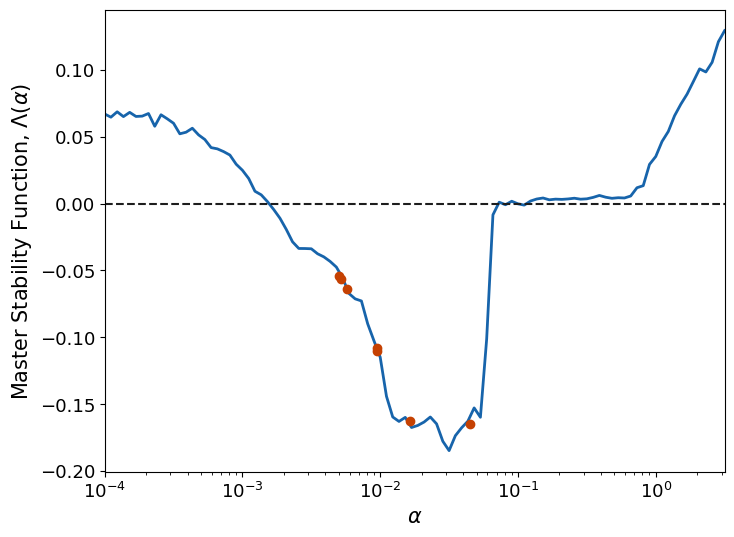

In [18]:
# We plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# MSF
ax.plot(interval, MSF,
        lw=2, c=plt.cm.Blues(0.8), zorder=1,
        label="MSF")

# Lyapunov exponents associated to the eigenvalues of the Laplacian matrix
ax.scatter(spectrum[1:], hon_MSF,
        color=plt.cm.Oranges(0.8), zorder=10,
        label="MSF")

ax.hlines(y=0, xmin=10**-4, xmax=10,
          colors=plt.cm.Greys(0.9), ls="--")

ax.semilogx()
ax.set_xlim(10**-4,10**0.5)
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_xlabel("$\\alpha$", fontsize=15)
ax.set_ylabel("Master Stability Function, $\Lambda(\\alpha)$", fontsize=15)
#ax.legend(fontsize=15, frameon=False)

plt.show()